In [16]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [17]:
class Value:

    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.label = label

    def __repr__(self):
        return f"Value(data={self.data})"
    
    def __add__(self, other):
        out = Value(self.data + other.data, (self, other), '+')

        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward
        
        return out
    
    def __mul__(self, other):
        out = Value(self.data * other.data, (self, other), '*')

        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad   
        out._backward = _backward

        return out
    
    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
        out = Value(t, (self, ), 'tanh')

        def _backward():
            self.grad += (1 - t**2) * out.grad
        out._backward = _backward

        return out
    
    def backward(self):
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)

        self.grad = 1.0
        for node in reversed(topo):
            node._backward()

a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
e = a * b; e.label='e'
d = e + c; d.label='d'
f =  Value(-2.0, label='f')
L = d * f; L.label='L'
L

Value(data=-8.0)

In [18]:
d._prev

{Value(data=-6.0), Value(data=10.0)}

In [19]:
d._op

'+'

In [20]:
from graphviz import Digraph

def trace(root):
    # builds a set of all nodes and edges in a graph
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'})

    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        # for any value in the graph, create rectangular ('record') node for it
        dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
        if n._op:
            # if this value is the result of an operation, create an op node for it
            dot.node(name = uid + n._op, label = n._op)
            # and connect this node to it
            dot.edge(uid + n._op, uid)
    
    for n1, n2 in edges:
        # connect n1 to the op node of n2
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    
    return dot

L = d * f

dL/dd = f

(f(x+h)-f(x))/h

((d+h)*f - d*f)/h

(d*f + h*f - d*f)/h

(h*f)/h

f

dL/dc = dd/dc * dL/dd = 1 * -2.0
dL/de = dd/de * dL/dd = 1 * -2.0

dd/dc = 1.0
dd/de = 1.0

d = e + c

((c+h + e) - (c + e))/h

h/h

1.0

dL/da = dL/de * de/da

e = a * b

de/da = b

In [21]:
# L.grad = 1.0
# f.grad = 4.0
# d.grad = -2.0
# c.grad = -2.0
# e.grad = -2.0
# a.grad = -2.0 * -3.0
# b.grad = -2.0 * 2.0

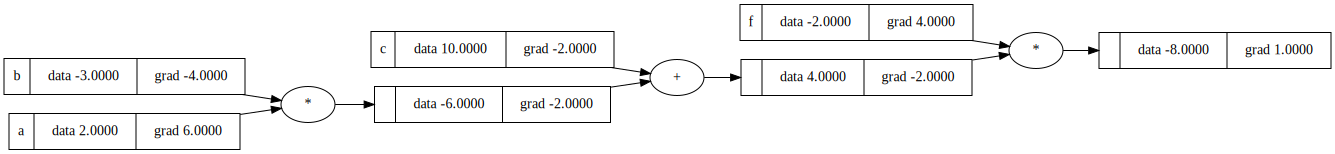

In [32]:
L.backward()
draw_dot(L)

In [23]:
# increasing leaf nodes along gradient makes result more positive
a.data += 0.01 * a.grad
b.data += 0.01 * b.grad
c.data += 0.01 * c.grad
f.data += 0.01 * f.grad

e = a * b 
d = e + c
L = d * f

print(L.data)

-8.0


In [24]:
def lol():
    # calculate derivative by inreasing value of the derivative you're looking for by h
    h = 0.001

    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a * b; e.label='e'
    d = e + c; d.label='d'
    f =  Value(-2.0, label='f')
    L = d * f; L.label='L'
    L1 = L.data

    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a * b; e.label='e'
    d = e + c; d.label='d'
    d.data += h
    f =  Value(-2.0, label='f')
    L = d * f; L.label='L'
    L2 = L.data

    print((L2 - L1)/h)

lol()


-2.000000000000668


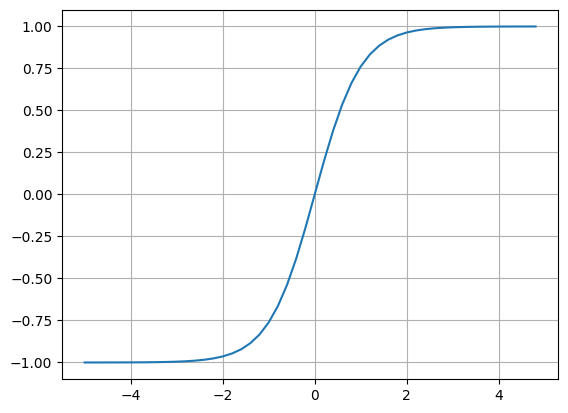

In [25]:
plt.plot(np.arange(-5,5,0.2), np.tanh(np.arange(-5,5,0.2))); plt.grid();

In [38]:
# inputs x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1, w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')

# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label='x1*w1'
x2w2 = x2*w2; x2w2.label='x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label='x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label='n'

o = n.tanh(); o.label='o'

In [27]:
# o = tanh(n)
# do/dn = 1 - o**2

1 - o.data**2

0.4999999999999999

In [28]:
# o.grad = 1.0
# n.grad = 0.5
# # all children nodes inherit the same gradient when plus operator was used
# b.grad = 0.5
# x1w1x2w2.grad = 0.5
# x1w1.grad = 0.5
# x2w2.grad = 0.5

# x1.grad = w1.data * x1w1.grad
# w1.grad = x1.data * x1w1.grad

# x2.grad = w2.data * x2w2.grad
# w2.grad = x2.data * x2w2.grad

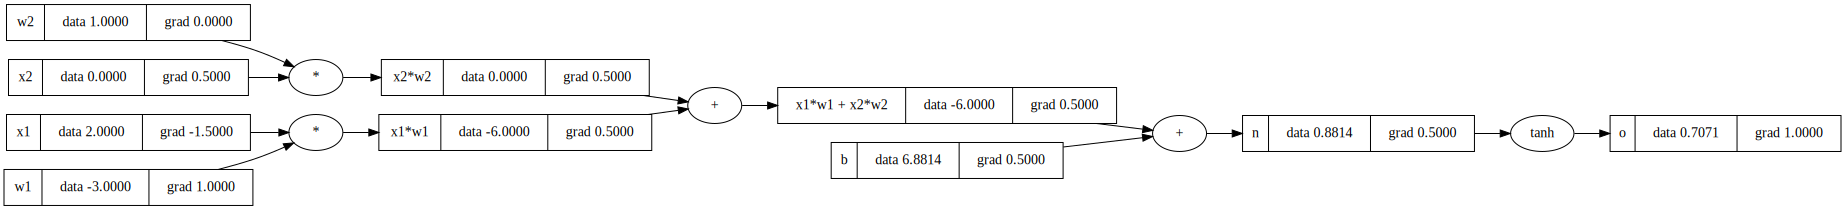

In [41]:
draw_dot(o)

In [40]:
o.backward()

In [31]:
topo = []
visited = set()
def build_topo(v):
    if v not in visited:
        visited.add(v)
        for child in v._prev:
            build_topo(child)
        topo.append(v)
build_topo(o)
topo

[Value(data=-3.0),
 Value(data=2.0),
 Value(data=-6.0),
 Value(data=0.0),
 Value(data=1.0),
 Value(data=0.0),
 Value(data=-6.0),
 Value(data=6.881373587019543),
 Value(data=0.8813735870195432),
 Value(data=0.7071067811865476)]

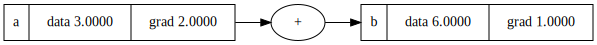

In [42]:
# Bug when using a variable multiple times -> Solution add up gradients
a = Value(3.0, label='a')
b = a + a; b.label='b'
b.backward()
draw_dot(b)

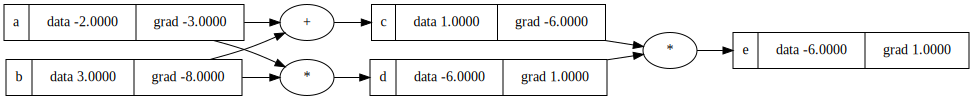

In [43]:
# elaborate example
a = Value(-2.0, label='a')
b = Value(3.0, label='b')
c = a + b; c.label='c'
d = a * b; d.label='d'
e = c * d; e.label='e'

e.backward()
draw_dot(e)